In [9]:
import torch
import os

import numpy as np
import matplotlib.pyplot as plt

from libs.networks import SirenNet
from libs.losses import NCCLoss, LNCCLoss, JacobianLossCoords
from libs.data import load_mindboggle, make_coords_tensor, fast_trilinear_interpolation, MetricMonitor, VectorCoords, BlockCoords

Load two MRI images from the Mindboggle dataset:

In [10]:
moving_paths = np.loadtxt('mindboggle/validation.csv', dtype=str)
fixed_paths = np.loadtxt('mindboggle/fixed.csv', dtype=str)
volumes_path = 'mindboggle/Mindboggle101_volumes/'
moving_path = volumes_path+moving_paths[0]
fixed_path = volumes_path+fixed_paths[0]
moving, moving_segmentations = load_mindboggle(moving_path)
fixed, fixed_segmentations = load_mindboggle(fixed_path)

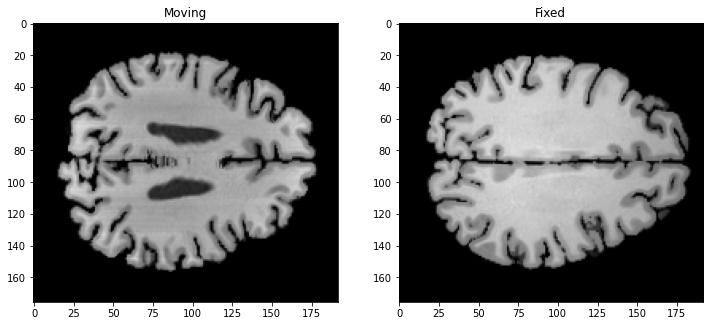

In [11]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(moving[:, :, 100], cmap='gray', vmin=-1, vmax=1)
axes[1].imshow(fixed[:, :, 100], cmap='gray', vmin=-1, vmax=1)
axes[0].set_title('Moving')
axes[1].set_title('Fixed')     
plt.show()

In [12]:
epochs=10 # number of the training epochs
epoch_save_visualization=5 # results will be visualized and saved every 5 epochs 
batch_size=64**3 # size of the vector for the image reconstruction
block_size=[32,32,32] # size of the 3D patch for the training
alpha_ncc=1 # weight for the normalized cross-correlation loss
alpha_jac=0.1 # weight for the jacobian determinant based regulizer
steps=500 # for each epoch, we will sample 500 [32,32,32] patches
learning_rate=0.00001 
device='cuda'
omega_0=30.0
trainable_omega_0=False 
results_path='example_custom_results/' # folder for the results   
n_dims = len(block_size)

Define the coordinate grid: 

In [14]:
coords_init = make_coords_tensor(moving.shape, is_vector=False)            

In this example, we will utilize an implicit network with the sine activation function: 

$$f(x)=sin(\omega_0 x),$$

where the $\omega_0$ parameter is set to 30. 

In [19]:
registration_network = SirenNet(input_dim=3, 
                                output_dim=3, 
                                hidden_dim=256, 
                                hidden_n_layers=5, 
                                last_layer_weights_small=True, 
                                is_last_linear=True, 
                                input_n_encoding_functions=0, 
                                input_omega_0=30.0, 
                                hidden_omega_0=30.0, 
                                trainable_omega_0=False).to(device)
    
optimizer = torch.optim.AdamW(lr=learning_rate, params=registration_network.parameters())

In [16]:
ncc = NCCLoss(is_tensor=False).to(device) # normalized cross-correlation loss function calculated over the [32,32,32] patch
lncc = LNCCLoss(is_tensor=False).to(device) # local normalized cross-correlation loss function, in this case the patch of [32,32,32] will be divided into [9,9,9] patches
jac = JacobianLossCoords(add_identity=False, is_tensor=False).to(device) # jacobian determinant based regulizer

pair_val = VectorCoords(coords=coords_init, scale_factor=1)
val_loader = DataLoader(pair_val, batch_size=batch_size, shuffle=False) # dataloader for the reconstruction

image_as_blocks = BlockCoords(coords=coords_init, scale_factor=0.5, block_size=block_size, steps=steps)
block_loader = DataLoader(image_as_blocks, batch_size=1, shuffle=True) # dataloader to sample [32,32,32] patches

In [17]:
os.makedirs(results_path, exist_ok=True) # folder for the results   

moving = torch.from_numpy(moving)
moving_image = moving.to(device, dtype=torch.float32)
fixed = torch.from_numpy(fixed)
fixed_image = fixed.to(device, dtype=torch.float32)

In [18]:
print(torch.cuda.memory_allocated('cuda'))

48911872


Main training loop: 

Epoch: 0. Train. jac: 0.0562 | ncc: -0.5457 | loss: -0.5400: 100%|███████████████████| 500/500 [00:42<00:00, 11.81it/s]
Epoch: 1. Train. jac: 0.1371 | ncc: -0.6112 | loss: -0.5975: 100%|███████████████████| 500/500 [00:40<00:00, 12.29it/s]
Epoch: 2. Train. jac: 0.1680 | ncc: -0.6615 | loss: -0.6447: 100%|███████████████████| 500/500 [00:41<00:00, 12.11it/s]
Epoch: 3. Train. jac: 0.1943 | ncc: -0.6973 | loss: -0.6779: 100%|███████████████████| 500/500 [00:40<00:00, 12.36it/s]
Epoch: 4. Train. jac: 0.2054 | ncc: -0.7102 | loss: -0.6896: 100%|███████████████████| 500/500 [00:40<00:00, 12.29it/s]


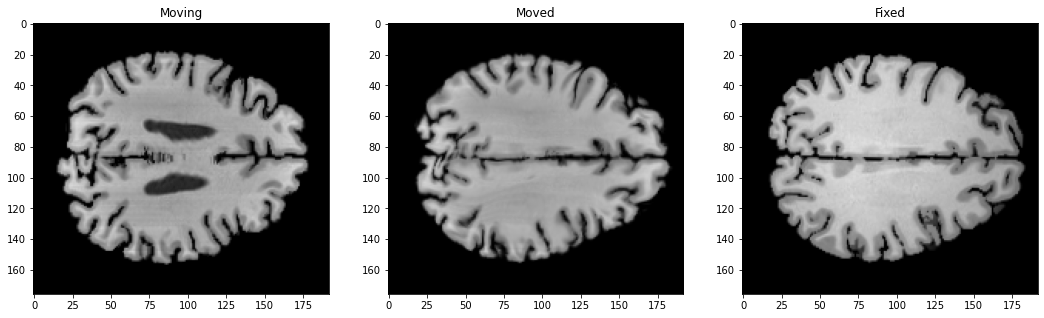

Epoch: 5. Train. jac: 0.2212 | ncc: -0.7186 | loss: -0.6965: 100%|███████████████████| 500/500 [00:40<00:00, 12.40it/s]
Epoch: 6. Train. jac: 0.2315 | ncc: -0.7397 | loss: -0.7166: 100%|███████████████████| 500/500 [00:40<00:00, 12.50it/s]
Epoch: 7. Train. jac: 0.2243 | ncc: -0.7738 | loss: -0.7513: 100%|███████████████████| 500/500 [00:40<00:00, 12.48it/s]
Epoch: 8. Train. jac: 0.2460 | ncc: -0.7581 | loss: -0.7335: 100%|███████████████████| 500/500 [00:40<00:00, 12.48it/s]
Epoch: 9. Train. jac: 0.2595 | ncc: -0.7728 | loss: -0.7468: 100%|███████████████████| 500/500 [00:40<00:00, 12.46it/s]


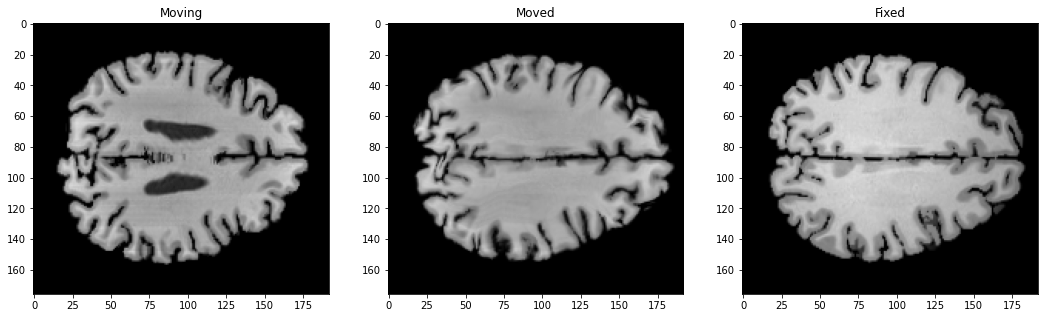

In [20]:
for epoch in range(epochs):

    stream = tqdm(block_loader)
    loop_monitor = MetricMonitor()

    for i, image_coords in enumerate(stream, start=0):

        image_coords = image_coords.squeeze().to(device, dtype=torch.float32)

        # predict the displacement vectors and determine the deformation field: 
        
        displacement_vector, coords = registration_network(image_coords.view([np.prod(block_size), n_dims]))
        deformation_field = torch.add(displacement_vector, coords)
        
        # extract the patches based on the moving and fixed images: 

        moved_image_pixels = fast_trilinear_interpolation(moving_image, deformation_field[:,0], deformation_field[:,1], deformation_field[:,2]).view(block_size)
        fixed_image_pixels = fast_trilinear_interpolation(fixed_image, coords[:,0], coords[:,1], coords[:,2]).view(block_size)

        moved_image_pixels = moved_image_pixels.unsqueeze(0).unsqueeze(0)
        fixed_image_pixels = fixed_image_pixels.unsqueeze(0).unsqueeze(0)

        ################################
        
        # calculate the loss functions and update the loss tracker

        loss_all = torch.tensor(0)

        loss_ncc = (ncc(moved_image_pixels, fixed_image_pixels) + lncc(moved_image_pixels, fixed_image_pixels)) / 2
        loss_jac = jac(coords, deformation_field)

        if alpha_ncc>0:

            loss_all = loss_all + alpha_ncc*loss_ncc        

        if alpha_jac>0:

            loss_all = loss_all + alpha_jac*loss_jac        

        loop_monitor.update('jac', loss_jac.item())
        loop_monitor.update('ncc', loss_ncc.item())
        loop_monitor.update('loss', loss_all.item())
        stream.set_description('Epoch: {epoch}. Train. {metric_monitor}'.format(epoch=epoch, metric_monitor=loop_monitor))

        optimizer.zero_grad()
        loss_all.backward()
        optimizer.step()
        
    # reconstruct the moved image based on the total deformation field (all image pixels), and save the results (total deformation field + weights)

    if not (epoch+1) % epoch_save_visualization:

        with torch.no_grad():

            for k, image_coords in enumerate(val_loader):

                image_coords = image_coords.squeeze().to(device, dtype=torch.float32)

                displacement_vector, coords = registration_network(image_coords)
                deformation_field = torch.add(displacement_vector, coords)

                deformation_field = deformation_field.cpu().detach().squeeze()

                if k==0:

                    total_deformation_field = deformation_field

                else:

                    total_deformation_field = torch.cat((total_deformation_field, deformation_field), 0)

            temp_moved = fast_trilinear_interpolation(moving, total_deformation_field[:,0], total_deformation_field[:,1], total_deformation_field[:,2]).view(moving.shape)  
            temp_moved = temp_moved.numpy().squeeze()

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(moving[:, :, 100], cmap='gray', vmin=-1, vmax=1)
        axes[1].imshow(temp_moved[:, :, 100], cmap='gray', vmin=-1, vmax=1)
        axes[2].imshow(fixed[:, :, 100], cmap='gray', vmin=-1, vmax=1)

        axes[0].set_title('Moving')
        axes[1].set_title('Moved')
        axes[2].set_title('Fixed')            
        plt.show()
        
        del temp_moved

        np.save(results_path+str(epoch+1)+'_deformation_field.npy', total_deformation_field.view(*moving.shape, 3).numpy())        

        save_state = {'state_dict': registration_network.state_dict(),
                      'optimizer': optimizer.state_dict(),
                      'loss_all': loss_all.item()}         

        torch.save(save_state, results_path + str(epoch+1) + '.pth.tar')   
        


Determine the moved image:

In [21]:
with torch.no_grad():

    for k, image_coords in enumerate(val_loader):

        image_coords = image_coords.squeeze().to(device, dtype=torch.float32)

        displacement_vector, coords = registration_network(image_coords)
        deformation_field = torch.add(displacement_vector, coords)

        deformation_field = deformation_field.cpu().detach().squeeze()

        if k==0:

            total_deformation_field = deformation_field

        else:

            total_deformation_field = torch.cat((total_deformation_field, deformation_field), 0)

    moved = fast_trilinear_interpolation(moving, total_deformation_field[:,0], total_deformation_field[:,1], total_deformation_field[:,2]).view(moving.shape)  
    moved = moved.numpy().squeeze()

Final visualization:

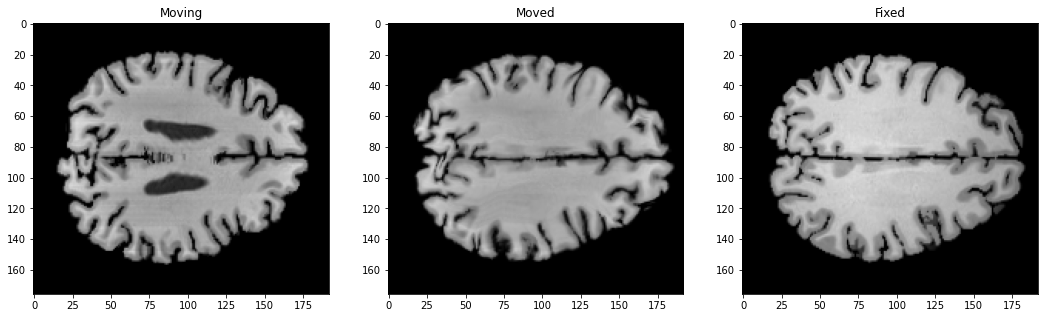

In [22]:
fig, axes = plt.subplots(1,3, figsize=(18,6))
axes[0].imshow(moving[:, :, 100], cmap='gray', vmin=-1, vmax=1)
axes[1].imshow(moved[:, :, 100], cmap='gray', vmin=-1, vmax=1)
axes[2].imshow(fixed[:, :, 100], cmap='gray', vmin=-1, vmax=1)

axes[0].set_title('Moving')
axes[1].set_title('Moved')
axes[2].set_title('Fixed')            
plt.show()